In [0]:
#сетка для распознавания жестов без обработки
#dataset:
#https://github.com/ardamavi/Sign-Language-Digits-Dataset

!pip install keras
!pip install pydot-ng
!pip install six numpy scipy Pillow matplotlib scikit-image opencv-python imageio Shapely
!pip install imgaug
!pip install git+https://github.com/aleju/imgaug
!pip install -U -q PyDrive

In [3]:
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt 
import imgaug as ia
import glob
import pandas as pd
import cv2
%matplotlib inline  

from tensorflow import keras
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.metrics import confusion_matrix
from keras.models import model_from_yaml
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from PIL import Image
from google.colab import files
from sklearn import preprocessing
from imgaug import augmenters as iaa
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pathlib import Path
from random import randint

Using TensorFlow backend.


In [0]:
!unzip Sign-Language-Digits-Dataset-master.zip

In [0]:
def show_image(img):
  plt.figure()
  plt.imshow(img)
  plt.gca().get_xaxis().set_visible(False)
  plt.gca().get_yaxis().set_visible(False)

In [0]:
def indices_to_one_hot(data, nb_classes):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

In [0]:
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=ia.ALL
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 5),
            [
                # Convert some images into their superpixel representation,
                # sample between 20 and 200 superpixels per image, but do
                # not replace all superpixels with their average, only
                # some of them (p_replace).
                sometimes(
                    iaa.Superpixels(
                        p_replace=(0, 1.0),
                        n_segments=(20, 200)
                    )
                ),

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),

                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),

                # Same as sharpen, but for an embossing effect.
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),

                # Search in some images either for all edges or for
                # directed edges. These edges are then marked in a black
                # and white image and overlayed with the original image
                # using an alpha of 0 to 0.7.
                sometimes(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0, 0.7)),
                    iaa.DirectedEdgeDetect(
                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),

                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255), per_channel=0.5
                ),

                # Either drop randomly 1 to 10% of all pixels (i.e. set
                # them to black) or drop them on an image with 2-5% percent
                # of the original size, leading to large dropped
                # rectangles.
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5),
                    iaa.CoarseDropout(
                        (0.03, 0.15), size_percent=(0.02, 0.05),
                        per_channel=0.2
                    ),
                ]),

                # Invert each image's chanell with 5% probability.
                # This sets each pixel value v to 255-v.
                iaa.Invert(0.05, per_channel=True), # invert color channels

                # Add a value of -10 to 10 to each pixel.
                iaa.Add((-10, 10), per_channel=0.5),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.5, 1.5), per_channel=0.5),

                # Improve or worsen the contrast of images.
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),

                # Convert each image to grayscale and then overlay the
                # result with the original with random alpha. I.e. remove
                # colors with varying strengths.
                iaa.Grayscale(alpha=(0.0, 1.0)),

                # In some images move pixels locally around (with random
                # strengths).
                sometimes(
                    iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)
                ),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

In [0]:
path = 'Sign-Language-Digits-Dataset-master/Dataset/'
nb_classes = 10

images = []
labels = []

for i in range(nb_classes):
  for file_path in glob.glob(str(path)+str(i)+'/*.JPG'):
    try:
      images.append(np.array(Image.open(file_path).getdata()).reshape(100,100,3))
      labels.append(indices_to_one_hot([i],nb_classes))
    except:
      continue
  print(str(i) + ' / 9')
    
images = np.array(images)
labels = np.array(labels).reshape(len(images),nb_classes)

0 / 9
1 / 9
2 / 9
3 / 9
4 / 9
5 / 9
6 / 9
7 / 9
8 / 9
9 / 9


кол-во всех изображений : 2059
кол-во классов : 2059
0


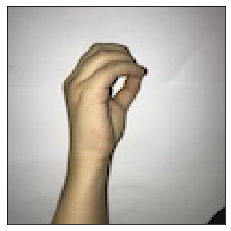

In [0]:
index = 0

print("кол-во всех изображений : " + str(len(images)))

show_image(images[index])
print(labels[index].argmax())

In [0]:
count_class = 205 #кол-во фото на один класс
train_percent = 70
test_percent = 20

train_X = []
train_Y = []
test_X = []
test_Y = []
val_X = []
val_Y = []

for i in range(0,len(images)-count_class,count_class):
  for j in range(count_class):
    if(j < count_class*train_percent/100):
      train_X.append(images[i+j])
      train_Y.append(labels[i+j])
    elif(j<count_class*(train_percent+test_percent)/100):
      test_X.append(images[i+j])
      test_Y.append(labels[i+j])
    else:
      val_X.append(images[i+j])
      val_Y.append(labels[i+j])

train_X = np.array(train_X)
train_Y = np.array(train_Y)
test_X = np.array(test_X)
test_Y = np.array(test_Y)
val_X = np.array(val_X)
val_Y = np.array(val_Y)

print("train % : " + str(train_percent) + "\t test % : " + str(test_percent)+ "\t val % : " + str(100-train_percent+test_percent))
print("train img : " + str(len(train_X)) + "\t test img : " + str(len(test_X))+ "\t val img : " + str(len(val_X)))

0


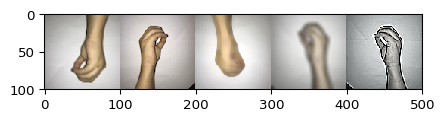

250


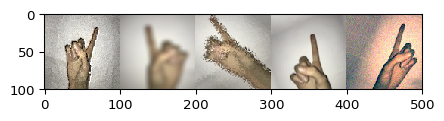

500


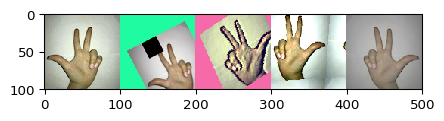

750


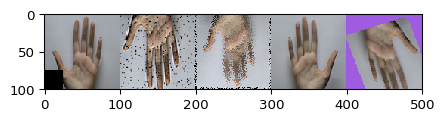

1000


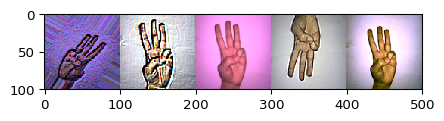

1250


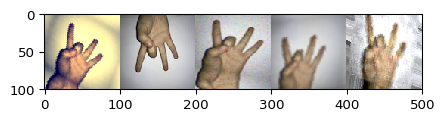

train img : 34560


In [0]:
train_X = train_X.astype('uint8')
count_images = 24 # кол-во аугментации каждого изображения

train_X_aug = []
train_Y_aug = []

for i in range(len(train_X)):
  train_X_aug.append(seq.augment_images(np.array([train_X[i] for _ in range(count_images)])))
  train_Y_aug.append([train_Y[i] for _ in range(count_images)])
  if((i % 250) == 0):
    print(i)
    seq.show_grid(train_X[i], rows=1, cols=5)

  
train_X_aug = np.array(train_X_aug).reshape(len(train_X)*count_images,100,100,3)
train_Y_aug = np.array(train_Y_aug).reshape(len(train_X)*count_images,nb_classes)

print("train img : " + str(len(train_X_aug)))

In [0]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

lenet = Sequential()
lenet.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (100, 100,3)))
lenet.add(Convolution2D(6, kernel_size=(3, 3), activation='relu'))
lenet.add(MaxPooling2D(pool_size=(3, 3)))
lenet.add(Convolution2D(16, (3, 3), activation='relu'))
lenet.add(MaxPooling2D(pool_size=(3, 3)))
lenet.add(Flatten())
lenet.add(Dense(120, activation='relu'))
lenet.add(Dense(84, activation='relu'))
lenet.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
lenet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 6)         168       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 16)        880       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               192120    
__________

In [0]:
lenet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history_object = lenet.fit(train_X_aug, 
                           train_Y_aug,
                           batch_size      = 800,
                           nb_epoch        = 15,
                           verbose         = 1,
                           validation_data = (val_X, val_Y))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 34560 samples, validate on 610 samples
Epoch 1/15
34560/34560 [==============================] - 5s 153us/step - loss: 1.7401 - acc: 0.6264 - val_loss: 0.1773 - val_acc: 0.9426
Epoch 2/15
34560/34560 [==============================] - 4s 119us/step - loss: 1.1018 - acc: 0.6268 - val_loss: 0.1462 - val_acc: 0.9459
Epoch 3/15
34560/34560 [==============================] - 4s 119us/step - loss: 0.9974 - acc: 0.6575 - val_loss: 0.1339 - val_acc: 0.9525
Epoch 4/15
34560/34560 [==============================] - 4s 119us/step - loss: 0.9295 - acc: 0.6805 - val_loss: 0.1211 - val_acc: 0.9557
Epoch 5/15
34560/34560 [==============================] - 4s 119us/step - loss: 0.8717 - acc: 0.6977 - val_loss: 0.1199 - val_acc: 0.9525
Epoch 6/15
34560/34560 [==============================] - 4s 119us/step - loss: 0.8213 - acc: 0.7128 - val_loss: 0.1113 - val_acc: 0.9607
Epoch 7/15
34560/34560 [==============================] - 4s 117us/step - loss: 0.7722 - acc: 0.7305 - val_loss: 0.1112 - va

In [0]:
score = lenet.evaluate(test_X, test_Y, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11167001042683956
Test accuracy: 0.9655737704918033


8


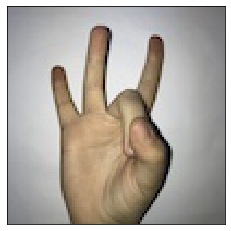

In [0]:
test_index = 500

result = lenet.predict(np.array([test_X[test_index]]))
print(result.argmax())
show_image(test_X[test_index])

[[0.29870698 0.00891433 0.01347463 0.18059735 0.02268307 0.12934798
  0.01078339 0.16920172 0.09473453 0.07155605]]
0


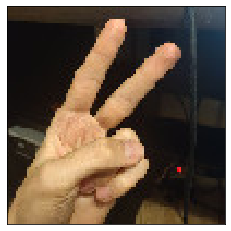

In [0]:
img = np.array(Image.open('kek.jpg').getdata()).reshape(100,100,3)
result = lenet.predict(np.array([img]))
print(result)
print(result.argmax())
show_image(img)